# RNN Simulation Trial

## Import the Libraries

In [1]:
# Import the libraries. #
import time
import numpy as np
import tensorflow as tf
import tf_ver2_rnn_tsa_scan as rnn
from matplotlib import pyplot as plt

## RNN Model Parameters

In [2]:
# Define the RNN model #
n_layers  = 1
out_size  = 1
hid_units = 32
n_seq_len = 100

rnn_model = rnn.RNN(
    n_layers, hid_units, out_size, 
    n_seq_len, rate=0.1, res_conn=True)
rnn_optim = tf.optimizers.Adam(learning_rate=0.01)

## Simulate some data

In [3]:
# Simulation parameters. #
n_validate = 251
n_simulate = 5001

### Cosine Function

In [4]:
# Simulate cosine function. #
max_bias  = 100
noise_std = 0.1

# Generate the validation data. #
x_v_range  = np.arange(n_validate)
y_v_signal = np.cos(x_v_range / 5.0)
y_validate = np.add(
    y_v_signal, np.random.normal(
        loc=0.0, scale=noise_std, size=n_validate))

# Generate the training data. #
x_t_range  = np.arange(n_simulate)
y_t_signal = np.cos(x_t_range / 5.0)
y_simulate = np.add(
    y_t_signal, np.random.normal(
        loc=0.0, scale=noise_std, size=n_simulate))

### Linear Trend with seasonality

In [5]:
y_t_trend = 0.01 * x_t_range
y_v_trend = np.add(
    np.random.choice(20), 0.01 * x_v_range)

y_v_signal += y_v_trend
y_validate += y_v_trend
y_t_signal += y_t_trend
y_simulate += y_t_trend

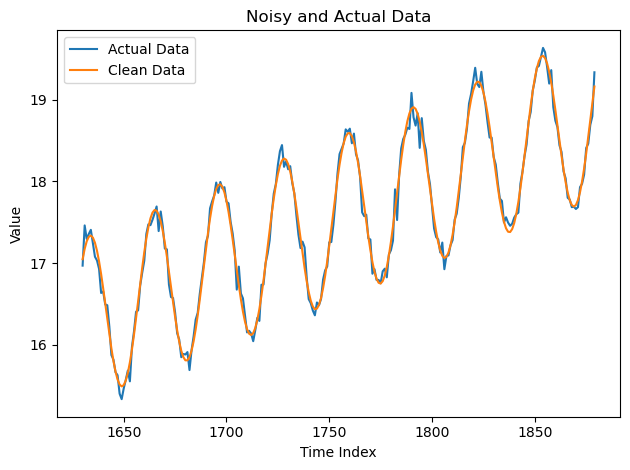

In [6]:
n_display = 250

idx_st = np.random.choice(n_simulate-n_display)
idx_en = idx_st + n_display
plt.plot(x_t_range[idx_st:idx_en], y_simulate[idx_st:idx_en])
plt.plot(x_t_range[idx_st:idx_en], y_t_signal[idx_st:idx_en])
plt.legend(["Actual Data", "Clean Data"])

plt.ylabel("Value")
plt.xlabel("Time Index")
plt.title("Noisy and Actual Data")
plt.tight_layout()

## Train the RNN Model

In [7]:
# Train the RNN network. #
batch_sz  = 128
disp_loss = 50
cool_step = 250
num_iters = 250

train_loss = 0.0
for n_iter in range(num_iters):
    if n_iter < 500:
        rnn_optim.lr.assign(1.0e-3)
    elif n_iter < 1000:
        rnn_optim.lr.assign(5.0e-4)
    else:
        rnn_optim.lr.assign(1.0e-4)
    
    batch_index = np.random.choice(
        n_simulate-n_seq_len, 
        size=batch_sz, replace=False)
    
    train_data = np.zeros(
        [batch_sz, n_seq_len], dtype=np.float32)
    label_data = np.zeros(
        [batch_sz, n_seq_len], dtype=np.float32)
    
    # Get the batch data. #
    for n_data in range(batch_sz):
        idx_st = batch_index[n_data]
        idx_en = idx_st + n_seq_len + 1
        tmp_bias = np.random.choice(100)
        
        tmp_simulate = np.add(
            tmp_bias, y_simulate[idx_st:idx_en])
        tmp_t_signal = np.add(
            tmp_bias, y_t_signal[idx_st:idx_en])
        train_data[n_data, :] = tmp_simulate[:-1]
        label_data[n_data, :] = tmp_t_signal[1:]
    
    # Extract the RNN parameters. #
    rnn_params = rnn_model.trainable_variables
    
    # Format the data to the correct dimensions. #
    train_data = np.expand_dims(train_data, axis=2)
    label_data = np.expand_dims(label_data, axis=2)
    
    with tf.GradientTape() as tape:
        # Forward pass. #
        y_predict = rnn_model.decode(
            train_data, training=True)
        y_errors  = y_predict - label_data
        
        # Predict only the last value. #
        y_errors = y_errors[:, -1, :]
        
        # Calculate the loss. #
        network_losses = tf.reduce_mean(
            tf.reduce_mean(tf.abs(y_errors), axis=1))
    
    # Update the weights. #
    rnn_grads = tape.gradient(
        network_losses, rnn_params)
    rnn_optim.apply_gradients(
        zip(rnn_grads, rnn_params))
    
    train_loss += network_losses.numpy()
    if (n_iter+1) % disp_loss == 0:
        batch_loss = train_loss / disp_loss
        train_loss = 0.0
        print("Average Training Loss at", 
              str(n_iter+1) + ":", batch_loss)
    
    if (n_iter+1) % cool_step == 0:
        time.sleep(120)

Average Training Loss at 50: 23.920682983398436
Average Training Loss at 100: 13.577919998168944
Average Training Loss at 150: 9.908003063201905
Average Training Loss at 200: 7.423286380767823
Average Training Loss at 250: 5.763054113388062


## Run the model on validation/test data

In [11]:
# Generate the validation data. #
x_v_range  = np.arange(n_validate)
y_v_signal = np.cos(x_v_range / 5.0)
y_validate = np.add(
    y_v_signal, np.random.normal(
        loc=0.0, scale=noise_std, size=n_validate))

y_v_trend = np.add(
    np.random.choice(20), 0.01 * x_v_range)
y_v_signal += y_v_trend
y_validate += y_v_trend

In [12]:
pred_data = np.zeros(
    [n_validate-n_seq_len], dtype=np.float32)

for n_test in range(n_validate-n_seq_len):
    idx_st = n_test
    idx_en = idx_st + n_seq_len
    
    input_seq = np.expand_dims(np.expand_dims(
        y_validate[idx_st:idx_en], axis=0), axis=2)
    yhat_pred = rnn_model.infer(input_seq)[0, -1, 0]
    
    pred_data[n_test] = yhat_pred

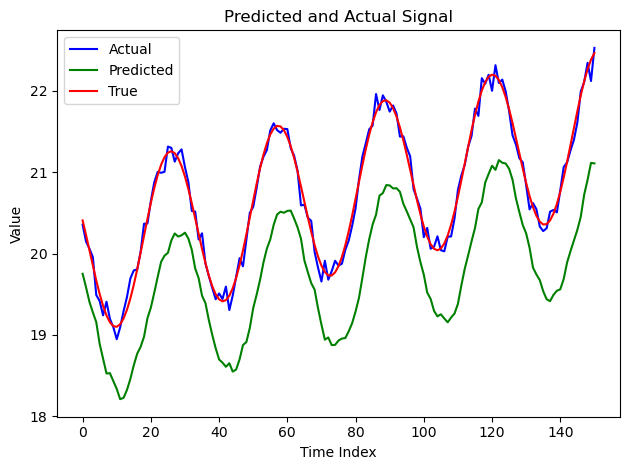

In [13]:
# Plot the predicted and actual data. #
idx_st = n_seq_len
x_time = n_seq_len + np.arange(n_validate-n_seq_len)

plt.plot(y_validate[idx_st:], color="blue")
plt.plot(pred_data, color="green")
plt.plot(y_v_signal[idx_st:], color="red")
plt.legend(["Actual", "Predicted", "True"])

plt.ylabel("Value")
plt.xlabel("Time Index")
plt.title("Predicted and Actual Signal")
plt.tight_layout()

## Miscelleneous